In [97]:
import numpy as np
from Utils.StegoSet import StegoSet
from Utils.utils import cut_image_into_blocks, concatenate_image
import os
from os import listdir
from os.path import isfile, join
import copy

from Utils.utils import custom_plot
from Utils.StegoSet import StegoSet
from Utils.utils import count_BER
from Algorithms.StegoAlgorithm import StegoAlgorithm as algo
from Utils.Experimenter import Experimenter
import matplotlib.pyplot as plt
import cv2

In [98]:
mypath = os.getcwd() + "/images/grey/"
onlyfiles = [mypath + f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles.remove(mypath + '.DS_Store')
my_set = StegoSet(onlyfiles[:1], init_way='files')
im = cut_image_into_blocks(my_set[0])

In [99]:
im.shape

(64, 64, 8, 8)

In [100]:
def get_chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def add_bits_into_seq(bits, seq, block, G=2):
    MIN_LEN = 4
    
    m = [-1 if bit == 0 else 1 for bit in bits]
    
    n = len(block)
    l = len(bits)
    emb_len = len(seq) // len(bits)
    
    if emb_len >= MIN_LEN:
        new_seq = [chunk for chunk in get_chunks(seq, emb_len)]
        
        for r_idx in range(n):
            for c_idx in range(n):
                f_idx = r_idx * n + c_idx
                chunk_idx = f_idx // emb_len
                coef_idx = f_idx % emb_len
                
                block[r_idx][c_idx] += new_seq[chunk_idx][coef_idx] * m[chunk_idx] * G
                block[r_idx][c_idx] = np.clip(block[r_idx][c_idx], 0, 255)
                    

        return block
    else:
        raise RuntimeError("The embedding sequence with len = {} is too short, need minimum {}".format(emb_len, MIN_LEN))

In [101]:
seq = np.random.randint(0,2,64)
seq = [-1 if i == 0 else 1 for i in np.random.randint(0,2,64)]

In [102]:
def get_bits_from_seq(seq, block, emb_len):
    temp_block = [c for c in get_chunks(block.reshape(64), emb_len)]
    temp_seq = [c for c in get_chunks(seq, emb_len)]
    
    res = []
    for i in range(len(temp_block)):
        bit = np.correlate(temp_block[i], temp_seq[i])
        if bit > 0:
            res.append(1)
        else:
            res.append(0)
    return res

In [104]:
bits = np.random.randint(0,2,16)
block = im[0][1]
emb_len = len(seq) // len(bits)

emb_block = add_bits_into_seq(bits, seq, block, G=1)
res = get_bits_from_seq(seq, emb_block, emb_len)
e = 0
for i in range(len(res)):
    if res[i] != bits[i]:
        e += 1

print(e/len(res))    

0.0625


In [109]:
def insert_message_SpreadSpectrum(image, message):
    MAX_LEN=16
    
    l = len(message)
    
    #step1
    blocks = cut_image_into_blocks(image)

    seqs = [[[-1 if i == 0 else 1 for i in np.random.randint(0,2,64)] for _ in range(len(blocks))] for _ in range(len(blocks))]
    
    n = len(blocks)
    m = len(blocks[0])
    emb_len = len(message) // (m*n)

    if emb_len <= MAX_LEN:
        message_chunks = [c for c in get_chunks(message, emb_len)]
        for i in range(len(message_chunks)):
            m = message_chunks[i]
            c_idx = i % n
            r_idx = i // n
            block = blocks[r_idx][c_idx]
            seq = seqs[r_idx][c_idx]
            
            blocks[r_idx][c_idx] = add_bits_into_seq(m, seq, block)
        return concatenate_image(blocks), {'seqs': seqs, 'emb_len':emb_len}
    else:
        raise RuntimeError("The embedding sequence with len = {} is too long, need max {}".format(emb_len, MAX_LEN))


def extract_message_SpreadSpectrum(im, seqs, emb_len):
    res = []

    blocks = cut_image_into_blocks(im)
    
    for r_idx in range(len(blocks)):
        for c_idx in range(len(blocks[0])):
            block = blocks[r_idx][c_idx]
            seq = seqs[r_idx][c_idx]
            
            res.extend(get_bits_from_seq(seq, block, emb_len))
    
    return res


def insert_message_iSpreadSpectrum(image, message, threshold=10):
    MAX_LEN=16
    
    l = len(message)
    
    #step1
    blocks = cut_image_into_blocks(image)

    seqs = [[[-1 if i == 0 else 1 for i in np.random.randint(0,2,64)] for _ in range(len(blocks))] for _ in range(len(blocks))]
    
    n = len(blocks)
    m = len(blocks[0])
    emb_len = len(message) // (m*n)

    if emb_len <= MAX_LEN:
        message_chunks = [c for c in get_chunks(message, emb_len)]
        for i in range(len(message_chunks)):
            m = message_chunks[i]
            c_idx = i % n
            r_idx = i // n
            block = blocks[r_idx][c_idx]
            seq = seqs[r_idx][c_idx]
            
            temp_block = block
            best_block = temp_block
            t = 0
            best_ber = 1
            
            while t < threshold and best_ber != 0:
                temp_block = add_bits_into_seq(m, seq, temp_block)
                ext_mes = get_bits_from_seq(seq, temp_block, emb_len)
                cur_ber = count_BER(ext_mes, m)
                if cur_ber < best_ber:
                    best_ber = cur_ber
                    best_block = temp_block
                
                t += 1
            blocks[r_idx][c_idx] = best_block
        return concatenate_image(blocks), {'seqs': seqs, 'emb_len':emb_len}
    else:
        raise RuntimeError("The embedding sequence with len = {} is too long, need max {}".format(emb_len, MAX_LEN))

In [115]:
SS = algo(insert_message_SpreadSpectrum, extract_message_SpreadSpectrum)
iSS = algo(insert_message_iSpreadSpectrum, extract_message_SpreadSpectrum)

exp_normal = Experimenter(my_set, SS, MAX_VALUE=65536, PERCENTAGES=[0.0625, 0.125, 0.25, 0.5, 1])
exp_iter = Experimenter(my_set, iSS, MAX_VALUE=65536, PERCENTAGES=[0.0625, 0.125, 0.25, 0.5, 1])
exp_normal.make_experiment()
exp_iter.make_experiment()

4096
8192
16384
32768
65536
4096
8192
16384
32768
65536


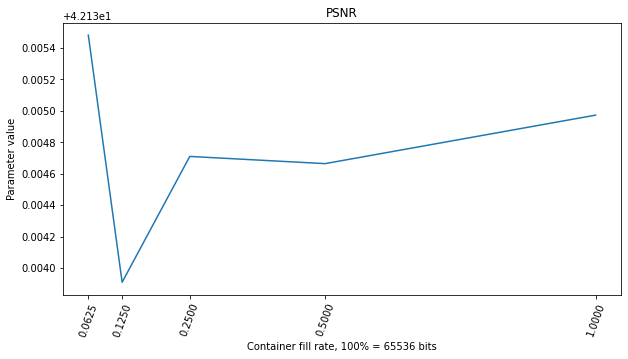

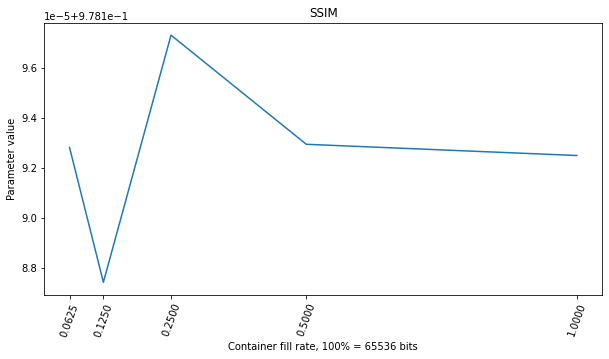

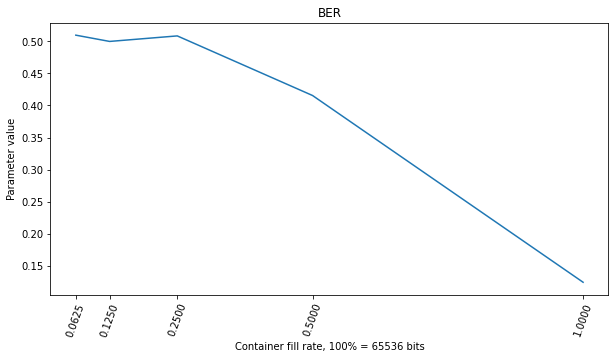

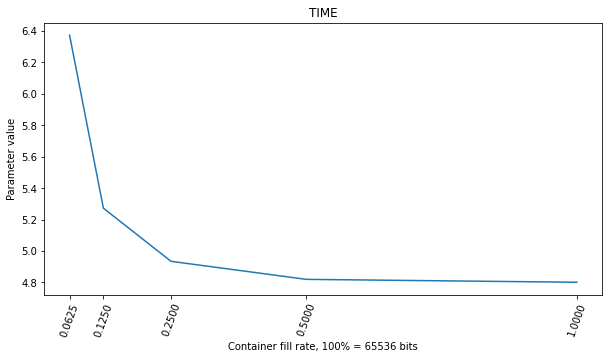

In [116]:
x_vals = exp_normal.percentages

data = {'PSNR': exp_normal.psnr_vals, 'SSIM': exp_normal.ssim_vals, 'BER': exp_normal.ber_vals, 'TIME': exp_normal.time_vals}

for d in data:
    plt.figure(figsize=(10, 5))
    custom_plot(x_vals, data[d])
    
    plt.xlabel('Container fill rate, 100% = 65536 bits')
    plt.ylabel('Parameter value')
    plt.xticks(x_vals, rotation = 70)
    plt.title(d)
    
    plt.show()

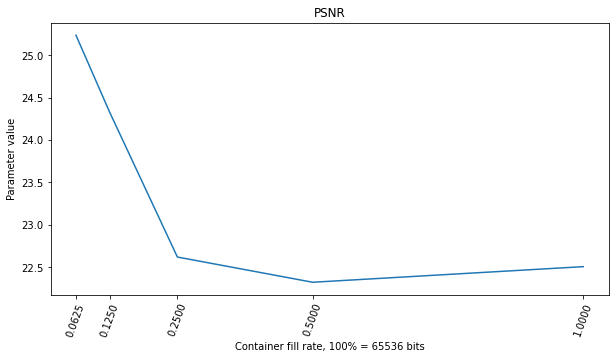

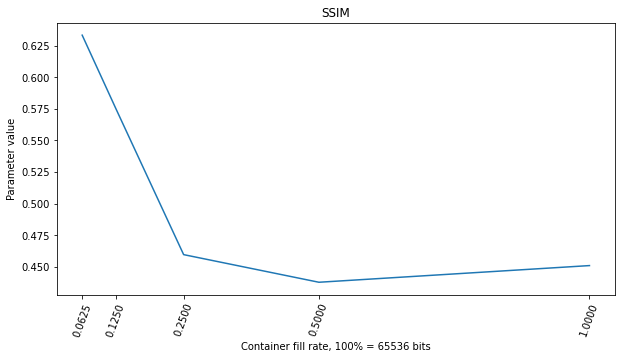

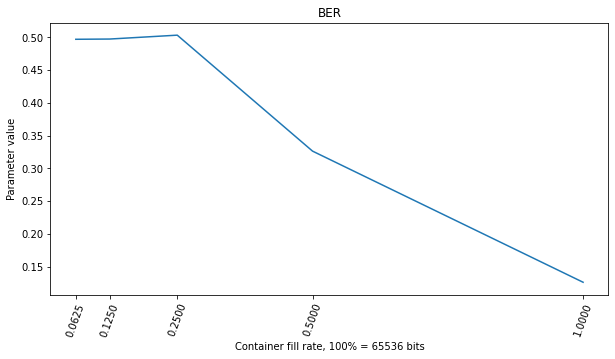

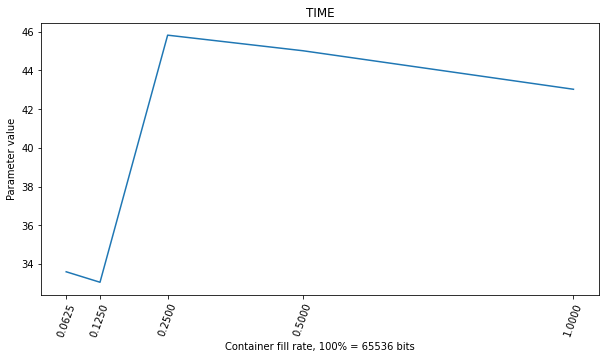

In [117]:
data = {'PSNR': exp_iter.psnr_vals, 'SSIM': exp_iter.ssim_vals, 'BER': exp_iter.ber_vals, 'TIME': exp_iter.time_vals}

for d in data:
    plt.figure(figsize=(10, 5))
    custom_plot(x_vals, data[d])
    
    plt.xlabel('Container fill rate, 100% = 65536 bits')
    plt.ylabel('Parameter value')
    plt.xticks(x_vals, rotation = 70)
    plt.title(d)
    
    plt.show()

In [118]:
exp_normal.psnr_vals

[42.13547968494841,
 42.133909413149055,
 42.134709056223095,
 42.134663239362425,
 42.13497147119166]

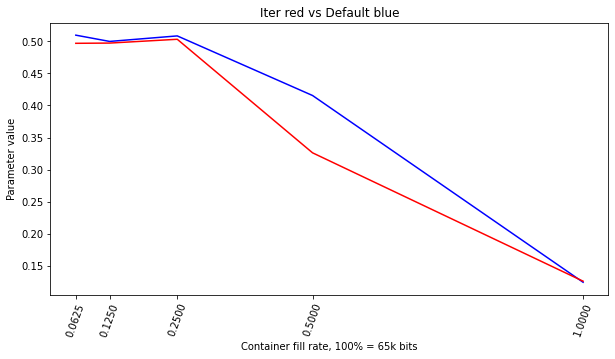

In [120]:
x_vals = exp_iter.percentages
plt.figure(figsize=(10, 5))

plt.plot(x_vals, exp_normal.ber_vals, 'b', x_vals, exp_iter.ber_vals, 'r')
plt.xlabel('Container fill rate, 100% = 65k bits')
plt.ylabel('Parameter value')
plt.xticks(x_vals, rotation = 70)
plt.title('Iter red vs Default blue')

plt.show()